In [1]:
import json
import pandas as pd

In [2]:
partidos_votos = json.load(open("data/partidos_votos_total.json"))


In [3]:
def json_to_df(votos, column_name):
    all_props = []
    for row in votos:
        party_name = row["nome"]
        party_id = row["id"]
        propositions = row['temas']
        for prop in propositions:
            dict_prop = {column_name:party_name}
            dict_prop.update(prop)
            all_props.append(dict_prop)
    all_props = pd.DataFrame(all_props)
    return all_props

In [4]:
all_props = json_to_df(partidos_votos, "party_name")
props_by_party = all_props[["party_name", "tema", "value"]].pivot(index="party_name", columns='tema', values='value').to_dict('index')

KeyError: 'id'

In [122]:
no_vote = "-10"
def calc_sim(propsA, propsB):
    equals = 0
    to_sum = 0
    for prop, vA in propsA.iteritems():
        if vA == no_vote:
            continue
        vB = propsB[prop]
        if vB == no_vote:
            continue
        if vA == vB:
            equals +=1
        to_sum+=1
    if to_sum == 0:
        return None, to_sum
    else:
        return equals / float(to_sum), to_sum
assert calc_sim({"a": 1, "b": 0}, {"a": 1, "b": 0}) == (1, 2)
assert calc_sim({"a": 1, "b": 0}, {"a": 1, "b": 1}) == (.5, 2)
assert calc_sim({"a": 1, "b": 0}, {"a": 0, "b": 1}) == (0.0, 2)
assert calc_sim({"a": 1, "b": 0}, {"a": 1, "b": no_vote}) == (1.0, 1)
assert calc_sim({"a": 1, "b": 0}, {"a": no_vote, "b": no_vote}) == (None, 0)

In [123]:
all_sim = []
parties_already_calculates = set()

def get_key(partyA, partyB):
    return "{}_{}".format(partyA, partyB)

for partyA, propsA in props_by_party.iteritems():
    for partyB, propsB in props_by_party.iteritems():
        if get_key(partyA, partyB) in parties_already_calculates or \
            get_key(partyB, partyA) in parties_already_calculates:
            continue

        if partyA == partyB:
            sim, used = 1,1
        else:
            sim, used = calc_sim(propsA, propsB)
        
        all_sim.append({"source": partyA, "target": partyB, "value": sim, "used": used})
        if partyA != partyB:
            all_sim.append({"target": partyA, "source": partyB, "value": sim, "used": used})
        parties_already_calculates.add(get_key(partyA, partyB))
        parties_already_calculates.add(get_key(partyB, partyA))

In [130]:
all_sim_df[all_sim_df.source == "pcb"]

,source,target,used,value


In [127]:
all_sim_df = pd.DataFrame(all_sim)
all_sim_df[all_sim_df.source == "pros"].sort_values(by="value", ascending=False)

,source,target,used,value
700,pros,pros,1,1.000000
725,pros,avante,1,1.000000
148,pros,prb,24,0.666667
713,pros,psl,24,0.666667
711,pros,ptdob,23,0.652174
364,pros,prp,20,0.650000
28,pros,ptn,22,0.636364
205,pros,ptc,19,0.631579
460,pros,pmn,19,0.631579
707,pros,psdc,19,0.631579


In [100]:
 set(all_sim_df[(all_sim_df.used >= 5)].source.drop_duplicates()) - set(all_sim_df[(all_sim_df.used >= 5) & (all_sim_df.value >= 0.75)].source.drop_duplicates())

{u'pps', u'pros', u'psb', u'pv'}

In [101]:
set(all_sim_df.source.drop_duplicates()) - set(all_sim_df[(all_sim_df.used >= 5)].source.drop_duplicates())

{u'avante', u'pmb', u'podemos'}

In [108]:
temp = all_sim_df[(all_sim_df.used >= 5) & (all_sim_df.value >= 0.75)]
all_sim = temp.to_dict('records')
parties = temp.source.drop_duplicates()
parties_without_similarity =  set(all_sim_df[(all_sim_df.used >= 5)].source.drop_duplicates()) - \
set(all_sim_df[(all_sim_df.used >= 5) & (all_sim_df.value >= 0.75)].source.drop_duplicates())
parties = list(parties) + list(parties_without_similarity)

In [109]:
len(all_sim)

158

In [110]:
for i, s in enumerate(all_sim):
    all_sim[i]['source'] = nodes_name_to_index[all_sim[i]['source']]
    all_sim[i]['target'] = nodes_name_to_index[all_sim[i]['target']]

In [114]:
def get_group(party):
    if party in ["psol", "pt", "pdt", "pcdob", "rede"]:
        return "red"
    elif party in ["dem", "solidaried", "psdb"]:
        return "blue"
    elif party in ["ptn", "prp", "pmn", "prtb", "ptdob", "ptc", "psdc"]:
        return "green"
    elif party in ["prb", "psl", "pp", "ptb", "pmdb", "psd", "pen", "pr", "phs", "psc"]:
        return "orange"
    else:
        return "black"
nodes = [{"id": n, "group": get_group(n)} for n in parties]
nodes_name_to_index = {n['id']: i for i,n in enumerate(nodes)}

    
links = all_sim

data = {"nodes": nodes,
        "links": links}

json.dump(data, open("analyses/data.json", "w"))

# Compare parties and deputies

In [456]:
def json_to_df(votos, column_name, id_column):
    all_props = []
    for row in votos:
        party_name = row["nome"]
        party_id = row[id_column]
        propositions = row['temas']
        for prop in propositions:
            dict_prop = {column_name:party_name, "id":party_id}
            dict_prop.update(prop)
            all_props.append(dict_prop)
    all_props = pd.DataFrame(all_props)
    return all_props

deputados_votos = json.load(open("data/deputados_votos_total.json"))

In [457]:
new_deputies_info = pd.read_csv("data/deputados_info_by_api.csv")
new_names_parties = {r['old_name']: r['new_name'] for i, r in pd.read_csv("data/parties_new_names.csv").iterrows()}
new_deputies_info['siglaPartido'] = new_deputies_info.apply(lambda x: new_names_parties.get(str(x['siglaPartido']), x['siglaPartido']), axis=1)

In [458]:
deputies_props = json_to_df(deputados_votos, "deputy_name", "id_dep")
deputies_props["id"] = deputies_props["id"].astype(int)
# x = deputies_props[deputies_props.value_name == u"não votou"][["deputy_name", "value_name"]].groupby("deputy_name").count().reset_index()
# deputies_low_votes = x[x.value_name > 20].deputy_name
# deputies_props = deputies_props[~deputies_props.deputy_name.isin(deputies_low_votes)]

props_by_deputy = deputies_props[["deputy_name", "tema", "value"]].pivot(index="deputy_name", columns='tema', values='value').to_dict('index')

In [459]:
deputy_party_df = pd.merge(deputies_props, new_deputies_info[["id","nome","siglaPartido", "siglaUf"]], 
                           on="id", how="left")[["deputy_name", "siglaPartido", "siglaUf"]].drop_duplicates(["deputy_name", "siglaPartido"])
deputy_party_df['siglaPartido'] = deputy_party_df['siglaPartido'].apply(lambda x: x.lower())
change = {"pode": "podemos", "sd": "solidaried"}
deputy_party_df.siglaPartido = deputy_party_df.siglaPartido.apply(lambda x: change[x] if x in change else x)
part_by_deputy = {d['deputy_name']: d['siglaPartido'] for index, d in deputy_party_df.iterrows()}

In [460]:
# pd.merge(deputies_props[deputies_props.deputy_name == u"José Fogaça"][["deputy_name", "value_name", "tema"]],
#          party_props[party_props.party_name == "mdb"][["id", "tema", "value_name"]], on="tema", how="left")

In [461]:
partidos_votos = json.load(open("data/partidos_votos_total.json"))
party_props = json_to_df(partidos_votos, "party_name", "nome")
props_by_party = party_props[["party_name", "tema", "value"]].pivot(index="party_name", columns='tema', values='value').to_dict('index')

In [462]:
no_vote_A = "-1"
no_vote_B = "-10"
ABSTENCAO = "-2"
OBSTRUCAO = "-3"
ARTIGO_17 = "-4"
PARTY_LIBERADO = "-1"
def calc_sim(propsA, propsB):
    equals = 0
    to_sum = 0
    for prop, vA in propsA.iteritems():
        vA = str(vA)
        if vA in [no_vote_A, ABSTENCAO, ARTIGO_17]: #SÓ PASSA 0, 1, -3
            continue
        if vA == OBSTRUCAO: #SÓ PASSA 0, 1
            vA = "0"
        vB = str(propsB[prop])
        if vB == no_vote_B: #SÓ PASSA 0, 1, -1
            continue
        if vB == PARTY_LIBERADO:
            equals += 1
            to_sum += 1
        elif vA == vB and vA in ["1", "0"]:
            equals +=1
            to_sum+=1
        else:
            to_sum+=1
            if vA not in ["1", "0"] and vB not in ["1", "0"]:
                print(vA, vB)
    if to_sum == 0:
        return None, to_sum
    else:
        return equals / float(to_sum), to_sum
assert calc_sim({"a": 1, "b": 0}, {"a": 1, "b": 0}) == (1, 2)
assert calc_sim({"a": 1, "b": 0}, {"a": 1, "b": 1}) == (.5, 2)
assert calc_sim({"a": 1, "b": 0}, {"a": 0, "b": 1}) == (0.0, 2)
assert calc_sim({"a": 1, "b": 0}, {"a": 1, "b": no_vote_B}) == (1.0, 1)
assert calc_sim({"a": 1, "b": 0}, {"a": no_vote_B, "b": no_vote_B}) == (None, 0)

In [463]:
all_sim = []
def get_key(partyA, partyB):
    return "{}_{}".format(partyA, partyB)

for deputy, props_deputy in props_by_deputy.iteritems():
    party = part_by_deputy[deputy]
    if party not in props_by_party:
        print party, deputy
        continue
    props_party = props_by_party[party]
    sim, used = calc_sim(props_deputy, props_party)
        
    all_sim.append({"source": deputy, "target": party, "value": sim, "used": used})

ppl Uldurico Junior


In [464]:
df = pd.DataFrame(all_sim)
df.rename(columns={"source": "deputado", "target": "partido", "used": "votacoes", "value": "similaridade"}, inplace=True)
df['similaridade'] = df['similaridade']*100
df_merged = pd.merge(df, deputy_party_df[["deputy_name", "siglaUf"]], left_on="deputado", right_on="deputy_name")

In [465]:
assert len(df_merged) == len(df)
df = df_merged
df = df.drop("deputy_name", axis=1)
df = df.rename(columns={"siglaUf":"uf", "deputado": "nome"})

In [466]:
json.dump(df[df.similaridade.notnull()].sort_values(by="similaridade", ascending=False).to_dict("records"), open("../../quemMeRepresenta/dados/deputado_partido_similaridade.json", "w"))

In [467]:
limit = 85
def separate_groups(x):
    if x == 100:
        return "1_100"
    if x >= limit:
        return "2_limit"
    return "3_all"
df["group"] = df.similaridade.apply(separate_groups)

In [468]:
count_df = df[["group", "nome"]].groupby("group").count().reset_index()

In [469]:
count_df['cum_sum'] = count_df.nome.cumsum()

In [470]:
count_df["porcent"] = count_df.cum_sum / count_df.cum_sum.max()
count_df["porcent"] = count_df["porcent"]*100
count_df = count_df.iloc[:2]
count_df

,group,nome,cum_sum,porcent
0,1_100,148,148,25.605536
1,2_limit,209,357,61.764706


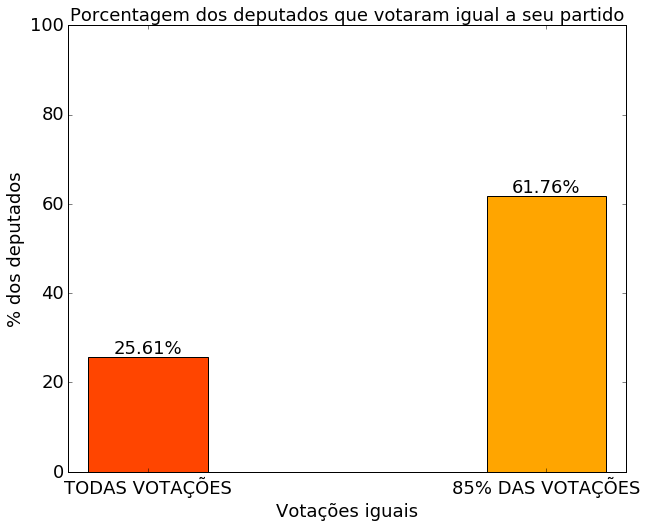

In [471]:
import matplotlib.pyplot as plt

x = range(len(count_df))
y = count_df.porcent
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.set_ylim(0,100)
plt.bar(x, y, color = ['orangered', 'orange'], align="center", width=0.3)
plt.xticks(x, [u"TODAS VOTAÇÕES", u"85% DAS VOTAÇÕES"])
plt.xlabel(u"Votações iguais")
plt.ylabel("% dos deputados")
# plt.ylim(0,100)
plt.title(u"""Porcentagem dos deputados que votaram igual a seu partido""")
rects = ax.patches

# Make some labels.
labels = ["{:.2f}%".format(i) for i in y]

for rect, label in zip(rects[:2], labels[:2]):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +  ax.texts +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

# plt.show()
plt.savefig("../../quemMeRepresenta/img/deputados_partidos.png", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)


In [230]:
# df = df.sort_values(by="similaridade", ascending=False)
# df["index"] = range(0,len(df))
# df["index"] = (df["index"] / len(df)) * 100

# y_limit = 85
# x_100 = int(df[df.similaridade < 100].iloc[0]['index'])
# x_limit = int(df[df.similaridade < y_limit].iloc[0]['index'])

# xs = sorted([x_100, x_limit, 50, 0, 100], reverse=True)

# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(111)
# x = df.similaridade
# y = df['index']
# plt.plot(x, y)
# # ax.fill_between(df['index'], 0,  df.similaridade, where=df.similaridade >= 85, facecolor='lightblue', interpolate=True)
# # ax.fill_between(df['index'], 0,  df.similaridade, where=df.similaridade >= 100, facecolor='blue')
# # plt.xticks(xs, map(lambda y: "{}%".format(y), xs))
# # plt.annotate('{}% similar'.format(y_limit), xy=(x_limit, y_limit), 
# #              xytext=(x_limit, y_limit))
# plt.xlabel("Porcentagem de deputados com pelo menos aquela similaridade")
# plt.ylabel("Similaridade com partido (0-100)")
# # plt.title(u"""26% dos deputados votaram igual ao seu partido em TODAS as votações \n 62% votaram igual ao seu partido em pelo menos 85% das votações""")
# # for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
# #              ax.get_xticklabels() + ax.get_yticklabels()):
# #     item.set_fontsize(14)
